This notebook closely follows the [benchmark notebook](https://www.drivendata.co/blog/mars-spectrometry-benchmark/) provided by the competition organizors. It will serve as a starting point in understanding the problem.

# Environment

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/notebooks'):
    main_path = p[:-len('/notebooks')]
if sys.path[0].endswith('/techdoc/content'):
    main_path = p[:-len('/techdoc/content')]
    
# Windows OS
if sys.path[0].endswith('\\notebooks'): 
    main_path = p[:-len('\\notebooks')]
if sys.path[0].endswith('\\techdoc\content'): 
    main_path = p[:-len('\\techdoc\content')]

sys.path[0] = main_path

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import config

# LOADING THE DATA

In [60]:
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Submission: (804, 11)


Check whether the samples are unique in the table.

In [13]:
print(metadata.sample_id.nunique() == metadata.shape[0])

True


In [14]:
metadata.head()

,sample_id,split,instrument_type,features_path,features_md5_hash
0,S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
1,S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
2,S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
3,S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
4,S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78


In [15]:
metadata.split.value_counts()

train    766
test     511
val      293
Name: split, dtype: int64

In [16]:
metadata.instrument_type.value_counts()

commercial     1494
sam_testbed      76
Name: instrument_type, dtype: int64

Get the file paths from the 'metadata' and save them as dictionaries, where the key will be a value from 0 onwards.

In [61]:
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()

# LEARNING ABOUT THE PROBLEM

## Goals and Objectives

- **goal**: detect the presence of certain families of chemical compounds in geological material samples using EGA data collected from Mars exploration missions.

The data is based on the EGA mass spectrograms from two different instruments, namely 'commercial' and 'sam_testbed':
- **Commercial instruments**: the data comes from commercially manufactured instruments that have been configured as SAM analogs at the Goddard and Johnson labs
- **SAM testbed**: the data comes from the SAM testbed at Goddard, a replica of the SAM instrument suite on Curiosity

**Data from these two instruments differ in many ways** - see [Problem Description Page](https://www.drivendata.org/competitions/93/nasa-mars-spectrometry/page/438/).
- Commercial instruments measure ion abundance as ion current in amps (Coulombs per second), while the SAM testbed measures abundance as counts per second. This results in their respective samples having drastically different orders of magnitude for their abundance values. As noted in the previous section, however, the key idea is to compare relative abundance values within one sample's run, and not to compare absolute abundance values across samples.
- Commercial instrument runs will have ion abundance measurements for all m/z values at every timestep of measurement. The SAM testbed can only measure abundance for one m/z value at a time—the mass spectrometer scans across m/z values in ascending order and cycles through its range of detection.
- Commercial instrument runs were generally configured to collect data for whole number m/z values from 0.0 to 100.0. The SAM testbed detects ions for a larger range of m/z values, up to 534.0 or 537.0, and data sometimes includes fractional m/z values.
    - In general, ions relevant to the detection of the label classes for this competition will be within the 0.0–100.0 range.
    - In general, if fractional m/z abundances are significant, they will be highly correlated to those of the nearest whole number m/z, e.g., m/z=1.9 will be highly correlated with 2.0. For EGA data, it is generally enough to only look at the whole number m/z values and ignore the fractional m/z values.

## Sample Analysis at Mars ([SAM](https://mars.nasa.gov/msl/spacecraft/instruments/sam/for-scientists/))
- SAM is an instrument suite aboard the Curiosity rover on Mars.
- takes up more than half of the science component load on the rover
- has 6 components: gas chromatograph, mass spectrometer, tunable laser spectrometer, sample manipulation system, sensitivity, and ovens.
- The *mass spectrometer* separates elements and compounds by mass for identification and measurement.

## Mass Spectrometry

What is mass spectrometry? [Khan Academy](https://www.khanacademy.org/science/ap-chemistry-beta/x2eef969c74e0d802:atomic-structure-and-properties/x2eef969c74e0d802:mass-spectrometry-of-elements/v/mass-spectrometry)

- isotope: different version of an element; can have different atomic mass
    - same number of protons but different number of neutrons
- the process:
    - get a sample
    - heat it up so that the sample starts floating around
    - bombard it with electrons, to knock off electrons from the sample and it will ionize some of the atoms, which now have charge
    - because they have charge they can be accelerated through the electric plates
    - enter into a strong magnetic field, which can bend their path. The bending depends on their mass, lower -> deflected more, and vice versa
    - detector is at the end which measures where they land and we can see which isotopes we have the most in nature.

- 'm/z': mass to charge ratio, where charge is the charge of the ions. If the charge is 1 then m/z is the same as the atomic mass. You need to adjust is it is not in atomic mass.
- the relative **abundance** of an isotope is the percentage of atoms with a specific atomic mass found in a naturally occurring sample of an element. It is determined, for each isotope, using mass spectrometry.
- because isotopes contain different numbers of neutrons, each isotope has a unique atomic mass.
- **atomic mass**: 1u=1/12

## Data Description

**Labels**:
1. Basalt
2. Carbonate
3. Chloride
4. Iron Oxide
5. Oxalate
6. Oxychlorine (chlorate, perchlorate)
7. Phyllosilicate
8. Silicate
9. Sulfate
10. Sulfide

Let's check the distribution of the target variables. First we sum all the target variables to see if this is a multiclass or multilabel problem. Then we analyze the distribution of the target labels.

We get that the targets can be multiple so this is a multilabel classification problem. Let's plot the distribution of target labels.

In [53]:
target_sum = train_labels.sum(axis=1, numeric_only=True)
all(target_sum == 1)

False

Get the sum for each target label in the sample:

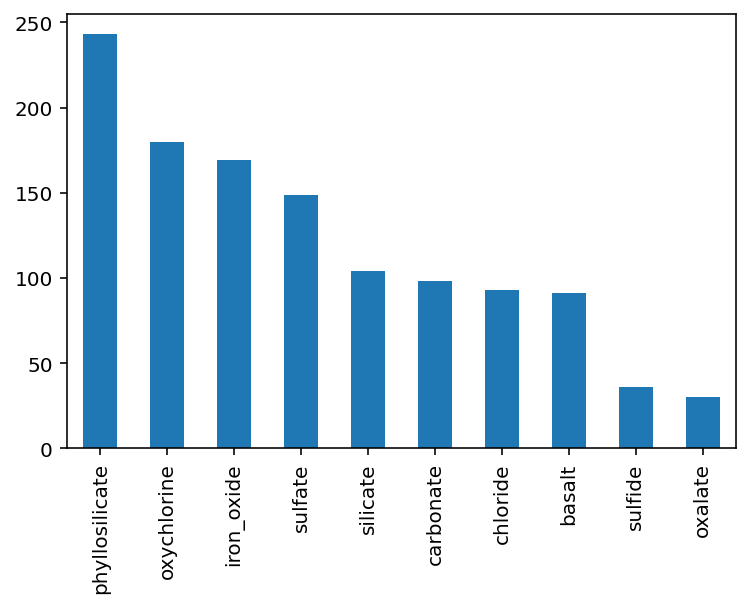

In [65]:
train_labels.sum(axis=0, numeric_only=True).sort_values(ascending=False).plot(kind='bar')
plt.show()

**Features** of the samples are given by:
- `time` - Time in seconds since start of a reference time.
- `temp` – Temperature of the sample in ºC at time of the measurement.
- `m/z` – Mass-to-charge ratio of ion being measured.
- `abundance` – Rate of ions detected, per second. Typically, all abundance values are compared in a relative way within one sample's analysis run. (Note that different samples will have abundances in different units, discussed more later.)

In [28]:
# Get the file path of a sample
fp = metadata.iloc[0,3]
print(fp)

# Load the sample data
ht = pd.read_csv(config.DATA_DIR + fp)
print(ht.shape)
ht.head()

train_features/S0000.csv
(38600, 4)


,time,temp,m/z,abundance
0,0.0,35.289,0.0,5.550957e-11
1,0.0,35.289,1.0,5.318589e-11
2,0.0,35.289,2.0,2.040361e-11
3,0.0,35.289,3.0,3.989464e-11
4,0.0,35.289,4.0,1.594648e-08


# EXPLORATORY DATA ANALYSIS

What proportion of instrument type do we have in the train, valid, and test samples? We get the column percentages with `pd.crosstab()` function and the argument `normalize='index'` to get the percentage by rows. We can see from the table below that the most commercial instrument is present in the train set, while in the majority of the SAM measurments are in the test set. Interestingly, there are no SAM measurements in the `val` dataset.

> In this competition, it is expected that modeling the SAM testbed data will be difficult, and that there will need to be transfer learning from the commercial instrument data in order to successfully model the SAM testbed data. 

> The top performers on the SAM testbed samples within the test set will be invited to submit a report of their methodology, to be judged by a panel of experts from NASA. 
([Ref](https://www.drivendata.co/blog/mars-spectrometry-benchmark/))

TODO Define the testing of the model on the whole sample using the CV and then separately on the commercial vs SAM instrument.  
TODO Can it be done to model on commercial only and do a transfer learning on the SAM instrument.

In [40]:
pd.crosstab(metadata.split, metadata.instrument_type, margins=True)

instrument_type,commercial,sam_testbed,All
split,,,
test,447,64,511
train,754,12,766
val,293,0,293
All,1494,76,1570


In [39]:
pd.crosstab(metadata.split, metadata.instrument_type, normalize='index')

instrument_type,commercial,sam_testbed
split,,
test,0.874755,0.125245
train,0.984334,0.015666
val,1.000000,0.000000
